# Weather Alert System

## Project Objectives
- To build a machine learning (ML) model that could be embedded into an homemade weather station made with arduino and sensors.
- The ML model shall outputs the likelihood of rain in the next X hours.
- The ML model shall takes as input features, the past hours of weather records for that given station, for example:
    - Temperatures
    - Pressures
    - Dew point and/or Humidity
    - Wind directions
    - Wind speeds
    - Rainfall levels

**Example of ML algorithm output**:
- The probability of rain within the next 4 hours is 0.9 with 95% confidence.

## Challenges
- Only the weather records of the chosen location are available to train the ML algorithm and to make predictions. It means that if it was deployed in Bordeaux, the ML cannot be trained using the weather records of another city such as Toulouse.
- Because our model is blind to surrounding measurements, it is unlikely that it will achieve high accuracy on long-term prediction. However, we are aiming at finding the right balance between accuracy, and time interval over which the ML algorithm makes prediction.

# Part I - Dataset Preparation
The objective of this section is to load the original dataset and to reduce it.
For this feasibility study, we have chosen the city of Annecy (France). We have downloaded the original **2018 South-East dataset**, as provided by https://meteonet.umr-cnrm.fr/.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from tqdm import tqdm

In [2]:
# We start to load the first 500 rows of the dataset
# data = pd.read_csv("SE2018.csv",nrows=1000,index_col = "date",parse_dates=True)

In [3]:
# We inspect the first 25 rows
# data.iloc[0:25,:]

The dataset is a structured time series, and all south-west of France stations are mixed here. The first step consists of finding the nearest station to the chosen city of Annecy.

GPS coordinates of Annecy are: latitude: 45.9; Longitude: 6.12.
<img src="img1.png">

In [4]:
# Find weather station that are close to our target GPS coordinates.
# data[(data["lat"]>45.8) & (data["lat"]<46) & (data["lon"]>6) & (data["lon"]<6.2)]

The closest match are station 74093001 and station 74182001. However, we noticed that only the second has sufficient meteorological records to be usable. For the first station, only temperature and precipiations were recored. For the second station, all parameters presented below were reported.

Consequently for the rest of the study, we focus on this particular station.

**Station 74182001**

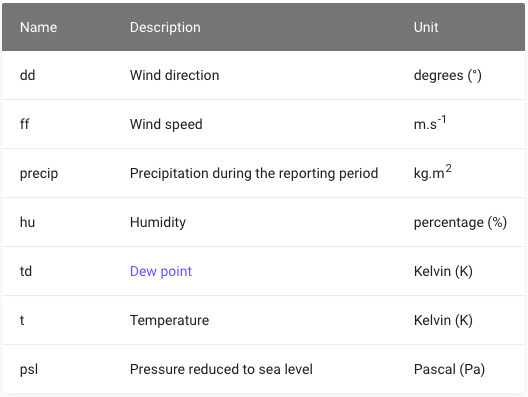

In [5]:
# Save only the data for this station as pickle (for faster loading in python with pandas)
# data[data["number_sta"]==74182001].to_pickle("./Annecy2018.pkl")

In this section we have identified the closest station of interest, isolated the relevant observation with that station only. Also we saved it into a .pkl file to make sure we can load it fast whenever we are working on the project.

# Part II - Exploratory Data Analysis
## General Informations

We load the reduced dataset (Annecy 2018) and use the .head() and .describe() method to get a glance of the data:

- The dataset contains 87423 observations.
- 4 columns concern the weather station itself: ID number, latitude, longitude, and height (altitude)
- 7 columns concern the meterological records: wind direction, wind speed, precipitation, humidity, temperature of dew point, temperature, and atmospheric pressure.

We rename a few columns, in order to make their name a little more explicit.

In [6]:
# Read file
data = pd.read_pickle("Annecy2018.pkl")
data.head()

,number_sta,lat,lon,height_sta,dd,ff,precip,hu,td,t,psl
date,,,,,,,,,,,
2018-01-01 00:00:00,74182001,45.93,6.09,455.0,220.0,2.7,0.2,83.0,277.15,279.85,101690.0
2018-01-01 00:06:00,74182001,45.93,6.09,455.0,200.0,3.4,0.2,85.0,277.35,279.65,101710.0
2018-01-01 00:12:00,74182001,45.93,6.09,455.0,190.0,3.5,0.2,87.0,277.45,279.45,101710.0
2018-01-01 00:18:00,74182001,45.93,6.09,455.0,190.0,3.5,0.0,87.0,277.45,279.45,101740.0
2018-01-01 00:24:00,74182001,45.93,6.09,455.0,210.0,3.7,0.4,86.0,277.35,279.55,101770.0


In [7]:
data.describe()

,number_sta,lat,lon,height_sta,dd,ff,precip,hu,td,t,psl
count,87423.0,87423.000000,87423.000000,87423.0,87377.000000,87377.000000,87392.000000,87412.000000,87412.000000,87412.000000,87412.000000
mean,74182001.0,45.928468,6.093064,455.0,170.835231,2.122308,0.012915,75.405860,280.253624,285.187871,101629.680822
std,0.0,0.000847,0.001694,0.0,126.027649,1.478899,0.104044,19.215567,6.086328,8.586444,730.019791
min,74182001.0,45.928000,6.090000,455.0,0.000000,0.000000,0.000000,14.000000,255.650000,260.950000,98390.000000
25%,74182001.0,45.928000,6.094000,455.0,40.000000,1.100000,0.000000,62.000000,275.950000,278.250000,101250.000000
50%,74182001.0,45.928000,6.094000,455.0,180.000000,1.800000,0.000000,80.000000,280.650000,284.550000,101630.000000
75%,74182001.0,45.928000,6.094000,455.0,300.000000,2.800000,0.000000,92.000000,285.250000,291.550000,102020.000000
max,74182001.0,45.930000,6.094000,455.0,360.000000,12.400000,8.200000,100.000000,293.050000,308.250000,104120.000000


In [8]:
# rename height_sta to "alt"
data.columns = ["ID","lat","long","alt","wdir","wspd","rain","hum","dew","temp","pressure"]

## Station Data: Latitude / Longitude / Altitude
* The min/max of latitude and longitude suggests that the location has changed. Either the weather station has been physically moved, or its actual GPS coordinates updated. However, this difference seems very negligible. We will ingore this effect.
* The altitude of this weather station is 455 m above see level and has not changed. This coroborate the hypothesis that the GPS coordinates have been updated rather than the station phyiscally moved.

## Wind Data
Wind data are comprised of 2 columns: wdir = wind direction, and wspd = wind speed:

**Wind Direction:** Since wind direction is a cycical variable, its measure in degrees does not reflect similarity between a wind direction at 1° and 359°. In practice, these directions are essentially the same. So we transform this cyclical feature into two x, y components such that Norht-South and East-West components are better captured (see code below).

**Wind speed:** it is provided in [m/s], we could change to km/h but that is not going to be much more informative.

In [9]:
def simWind(variable):
    """Transform cycical wind direction into a two directional components (N-S, E-W)
    INPUTS:
    - wind direction in degree (0 to 360)
    OUTPUT:
    - (x, y) tuple where x and y varies from -1 to 1 inform about the North/South (x) and 
    East-West (y) wind components.
    """
    x = round(math.cos(variable*2*math.pi/360),3)
    y = round(math.sin(variable*2*math.pi/360),3)
    return x,y
 
# PROOF: a full North and full East wind returns:
print("North wind: ",simWind(0))
print("East wind:",simWind(90))

# A composite North-East winds returns:
print("North-East",simWind(45))

# Similarly, south and west directions are handled such as:
print("South wind:",simWind(180))
print("West wind",simWind(270))

North wind:  (1.0, 0.0)
East wind: (0.0, 1.0)
North-East (0.707, 0.707)
South wind: (-1.0, 0.0)
West wind (-0.0, -1.0)


In [10]:
# Count missing values for wind direction
print("Wind direction missing:",data["wdir"].isna().sum())
# Counts missing values for winnd speed
print("Wind speed missing:",data["wspd"].isna().sum())

Wind direction missing: 46
Wind speed missing: 46


In [11]:
# Apply cyclical transformation and store the NS and EW component in new columns
data["wNS"] = data["wdir"].map(simWind).str[0]
data["wEW"] = data["wdir"].map(simWind).str[1]

# remove old wdir column
data.drop(["wdir"],axis=1,inplace=True)

# check the dataset
data.head()

,ID,lat,long,alt,wspd,rain,hum,dew,temp,pressure,wNS,wEW
date,,,,,,,,,,,,
2018-01-01 00:00:00,74182001,45.93,6.09,455.0,2.7,0.2,83.0,277.15,279.85,101690.0,-0.766,-0.643
2018-01-01 00:06:00,74182001,45.93,6.09,455.0,3.4,0.2,85.0,277.35,279.65,101710.0,-0.940,-0.342
2018-01-01 00:12:00,74182001,45.93,6.09,455.0,3.5,0.2,87.0,277.45,279.45,101710.0,-0.985,-0.174
2018-01-01 00:18:00,74182001,45.93,6.09,455.0,3.5,0.0,87.0,277.45,279.45,101740.0,-0.985,-0.174
2018-01-01 00:24:00,74182001,45.93,6.09,455.0,3.7,0.4,86.0,277.35,279.55,101770.0,-0.866,-0.500


Now, let's make a few plots to explore the wind data

Text(0, 0.5, 'Daily accumulated rain level [mm]')

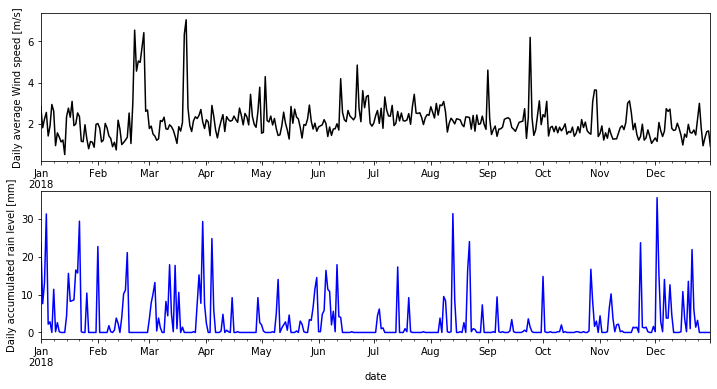

In [12]:
# Plot the daily wind speed average and compare to
plt.figure(figsize=(12,6))
plt.subplot(211)
data["wspd"].resample("D").mean().plot(color="black")
plt.ylabel("Daily average Wind speed [m/s]")
plt.subplot(212)
data["rain"].resample("D").sum().plot(color="blue")
plt.ylabel("Daily accumulated rain level [mm]")

**Discussion:**
Above, we plot the the average daily wind speed over the year and compare to the daily accumulated rainfall. Below, we plot an histogram of the NS and EW wind component. From these, we can retrieve the following informations:
1. On average, there was more wind in summer 2018 than in winter.
2. On average, there was less rain in summer 2018 than in winter.
3. Plot suggests that rainfall levels are inversely correlated with average wind speed.
4. There seems to be no prefered wind direction in the East-West component
5. There seems to be dominant Northerly wind, and almost not Southerly wind.

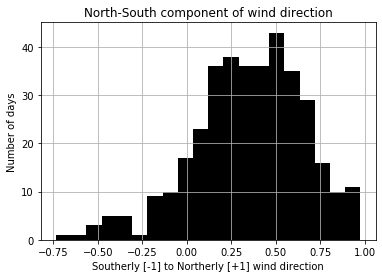

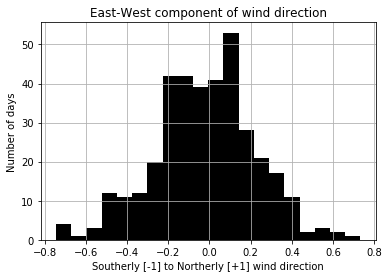

In [13]:
data["wNS"].resample("D").mean().hist(bins = 20,color="black")
plt.title("North-South component of wind direction")
plt.xlabel("Southerly [-1] to Northerly [+1] wind direction")
plt.ylabel("Number of days")
plt.show()

data["wEW"].resample("D").mean().hist(bins = 20,color="black")
plt.title("East-West component of wind direction")
plt.xlabel("Southerly [-1] to Northerly [+1] wind direction")
plt.ylabel("Number of days")
plt.show()

## Temperatures
Temperatures are recorded in kelvin. For more intuivite reading, we convert those into °C.

In [14]:
data["temp"] = data["temp"].map(lambda x:x-273.15)
data.head()

,ID,lat,long,alt,wspd,rain,hum,dew,temp,pressure,wNS,wEW
date,,,,,,,,,,,,
2018-01-01 00:00:00,74182001,45.93,6.09,455.0,2.7,0.2,83.0,277.15,6.7,101690.0,-0.766,-0.643
2018-01-01 00:06:00,74182001,45.93,6.09,455.0,3.4,0.2,85.0,277.35,6.5,101710.0,-0.940,-0.342
2018-01-01 00:12:00,74182001,45.93,6.09,455.0,3.5,0.2,87.0,277.45,6.3,101710.0,-0.985,-0.174
2018-01-01 00:18:00,74182001,45.93,6.09,455.0,3.5,0.0,87.0,277.45,6.3,101740.0,-0.985,-0.174
2018-01-01 00:24:00,74182001,45.93,6.09,455.0,3.7,0.4,86.0,277.35,6.4,101770.0,-0.866,-0.500


In [15]:
print("Temperature missing values:",data["temp"].isna().sum())

Temperature missing values: 11


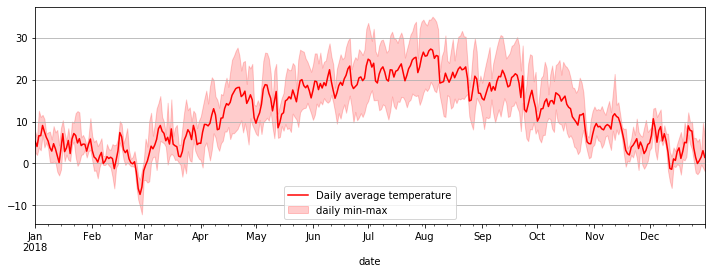

In [16]:
m = data["temp"].resample("D").agg(["mean","std","min","max"])
plt.figure(figsize=(12,4))
m["mean"].plot(label="Daily average temperature",color="red")
plt.fill_between(m.index, m["max"],m["min"],alpha = 0.2,label="daily min-max",color="red")
plt.legend(loc="lower center")
plt.grid(which="major",axis="y")
plt.show()

Text(0, 0.5, 'Probability Density')

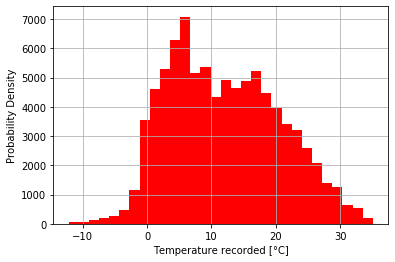

In [17]:
data["temp"].hist(bins=30,color="red",density=False)
plt.xlabel("Temperature recorded [°C]")
plt.ylabel("Probability Density")

In [18]:
print(data["temp"].describe())

print("Max temperature recorded:",round(data["temp"].max(),3))
print("Min temperature recorded:",round(data["temp"].min(),3))

count    87412.000000
mean        12.037871
std          8.586444
min        -12.200000
25%          5.100000
50%         11.400000
75%         18.400000
max         35.100000
Name: temp, dtype: float64
Max temperature recorded: 35.1
Min temperature recorded: -12.2


Temperature measurements are a little skewed. There are only a few temperatures below 0 degrees. Could that be attribute to the the thermal inertia brought by Annecy's lake? Most of the temperatures ranges between 0°C and 20°C. A very few extreme cold temperatures were observed, in February 2018 (down to -12.2°C) and several days of extreme hot temperatures were recorded in July-Aug (up to +35.1°C).

## Atmospheric Pressure
We plot the daily average atmospheric pressure and the rain level below. There is no indication of correlation from visual analysis of these plots, and this is confirmed using the .corr() method of pandas.

,rain,pressure
rain,1.000000,-0.039404
pressure,-0.039404,1.000000


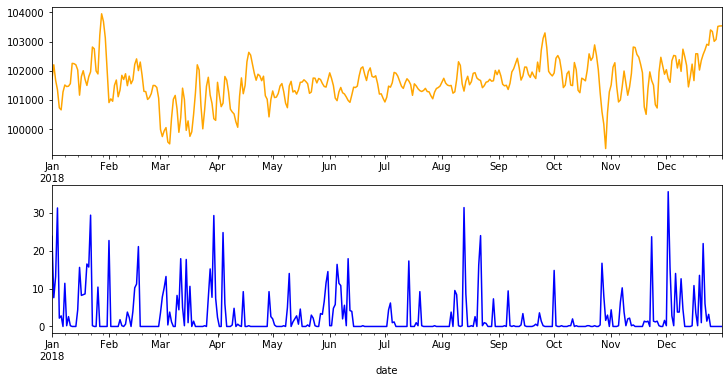

In [19]:
plt.figure(figsize=(12,6))
plt.subplot(211)
data["pressure"].resample("D").mean().plot(color="orange")
plt.subplot(212)
data["rain"].resample("D").sum().plot(color="blue")

data[["rain","pressure"]].corr()

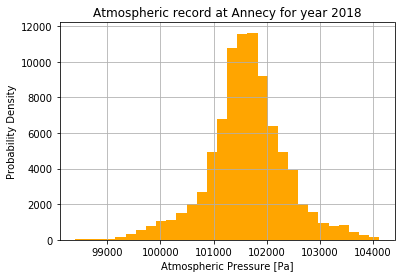

In [20]:
data["pressure"].hist(bins=30,color="orange",density=False)
plt.title("Atmospheric record at Annecy for year 2018")
plt.xlabel("Atmospheric Pressure [Pa]")
plt.ylabel("Probability Density")
plt.show()

We plot the probability density function of the atmospheric pressure records. These are pretty symmetric although it does not seems to follow exactly a gaussian, since tails are quite thick.

In [21]:
print("Pressure missing values:",data["pressure"].isna().sum())

Pressure missing values: 11


## Humidity
Humidity is the concentration of water vapour present in the air. According to Wikipedia, Humidity indicates the likelihood for precipitation, dew, or fog to be present. Therefore, this feature **may** be key in the development of our ML model.

Indeed, we can see that humidity and rain are slightly correlated (0.1).

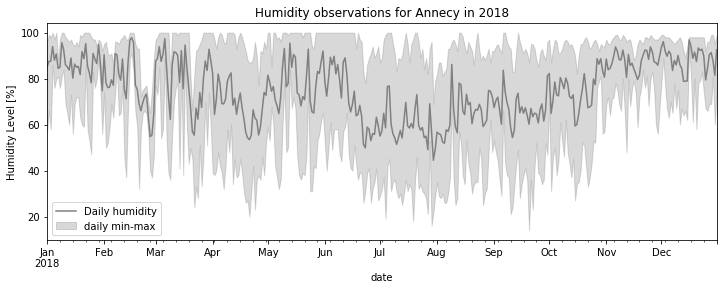

In [22]:
m = data["hum"].resample("D").agg(["mean","std","min","max"])
plt.figure(figsize=(12,4))
m["mean"].plot(label="Daily humidity",color="grey")
plt.fill_between(m.index, m["max"],m["min"],alpha = 0.3,label="daily min-max",color="grey")
plt.legend(loc="lower left")
plt.title("Humidity observations for Annecy in 2018")
plt.ylabel("Humidity Level [%]")
#plt.grid(which="major",axis="y")
plt.show()

In [23]:
data[["hum","rain"]].corr()

,hum,rain
hum,1.000000,0.100814
rain,0.100814,1.000000


In [24]:
print("Humidity missing values:",data["hum"].isna().sum())

Humidity missing values: 11


## Dew point
The dew point is the temperature to which air must be cooled to become saturated with water vapor. When further cooled, the airborne water vapor will condense to form liquid water (dew). When air cools to its dew point through contact with a surface that is colder than the air, water will condense on the surface. When the temperature is below the freezing point of water, the dew point is called the frost point, as frost is formed rather than dew. The measurement of the dew point is related to humidity. A higher dew point means there is more moisture in the air. [source: wikipedia]

The compute correlation is very low between the dew point temperature and the rain (see below)

In [25]:
# Convert into °C for improved readibility
data["dew"] = data["dew"].map(lambda x:x-273.15)

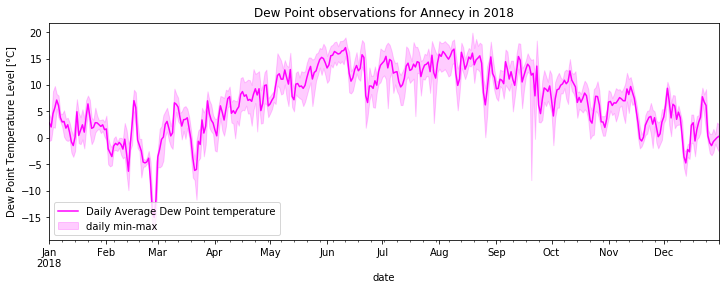

In [26]:
m = data["dew"].resample("D").agg(["mean","std","min","max"])
plt.figure(figsize=(12,4))
m["mean"].plot(label="Daily Average Dew Point temperature",color="magenta")
plt.fill_between(m.index, m["max"],m["min"],alpha = 0.2,label="daily min-max",color="magenta")
plt.legend(loc="lower left")
plt.title("Dew Point observations for Annecy in 2018")
plt.ylabel("Dew Point Temperature Level [°C]")
#plt.grid(which="major",axis="y")
plt.show()

In [27]:
data[["dew","rain"]].corr()

,dew,rain
dew,1.000000,0.016942
rain,0.016942,1.000000


In [28]:
print("dew point missing values:",data["dew"].isna().sum())

dew point missing values: 11


## Precipitation Analysis (Rain)

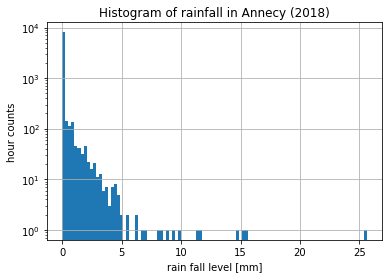

In [29]:
# histogram of precipitations per hour
index_hours = data.index.hour
rain_by_hour = data["rain"].resample("H").sum()
rain_by_hour.hist(bins=100)
plt.yscale('log')
plt.ylabel("hour counts")
plt.xlabel("rain fall level [mm]")
plt.title("Histogram of rainfall in Annecy (2018)")
plt.show()

In [30]:
# Compute the fraction of the time where there is a measurement and it is raining
f_rain = (data["rain"]!=0).sum()/data.shape[0]
print("In 2018 for Annecy, it was raining",round(f_rain*100,1),"% of the the time")

In 2018 for Annecy, it was raining 4.2 % of the the time


In [31]:
# Create a label column for classification purpose.
data["label"]=(data["rain"]>0)

In [32]:
# Check the percentage of rainy measurements:
data["label"].value_counts()
print(100*(data["label"]!=0).sum()/data.shape[0]) # it is consistent with the 4.2 % above

4.201411527858801


In [33]:
# inspect the new data
data.describe()

,ID,lat,long,alt,wspd,rain,hum,dew,temp,pressure,wNS,wEW
count,87423.0,87423.000000,87423.000000,87423.0,87377.000000,87392.000000,87412.000000,87412.000000,87412.000000,87412.000000,87377.000000,87377.000000
mean,74182001.0,45.928468,6.093064,455.0,2.122308,0.012915,75.405860,7.103624,12.037871,101629.680822,0.348424,-0.020693
std,0.0,0.000847,0.001694,0.0,1.478899,0.104044,19.215567,6.086328,8.586444,730.019791,0.667812,0.657617
min,74182001.0,45.928000,6.090000,455.0,0.000000,0.000000,14.000000,-17.500000,-12.200000,98390.000000,-1.000000,-1.000000
25%,74182001.0,45.928000,6.094000,455.0,1.100000,0.000000,62.000000,2.800000,5.100000,101250.000000,-0.174000,-0.643000
50%,74182001.0,45.928000,6.094000,455.0,1.800000,0.000000,80.000000,7.500000,11.400000,101630.000000,0.643000,0.000000
75%,74182001.0,45.928000,6.094000,455.0,2.800000,0.000000,92.000000,12.100000,18.400000,102020.000000,0.940000,0.643000
max,74182001.0,45.930000,6.094000,455.0,12.400000,8.200000,100.000000,19.900000,35.100000,104120.000000,1.000000,1.000000


In [34]:
# eliminate missing values with a simple forward fill
data = data.fillna(method="ffill")

## Covariance Analysis
Below we look at the correlation between the various tim series of our dataset. We choose a spearman correlation method in order to capture more efficiently non-linear correlations. From the plotted correlation matrix, we can say:
- Rain level is slightly positively correlated with humidity level as expected (effect size: 0.2, p-value < 0.01)
- Rain level is slightly negatively correlated with temperature (effect size: -0.1, p-value < 0.01)
- Rain level is slightly negatively correlated with wNS (effect size: -0.086, p-value < 0.01).

**Rain is overall only weakly correlated to the features we have, and therefore we expect that some features extraction shall be performed in the pre-processing phase**.

Other correlation revealed by this heatmap are:
- dew point & humidity
- wind speed and humidity
- temperature and humidity
- wind speed and temperature
- humidity and East-West wind component

The highest correlation observed is for temperature & dew point temperature.

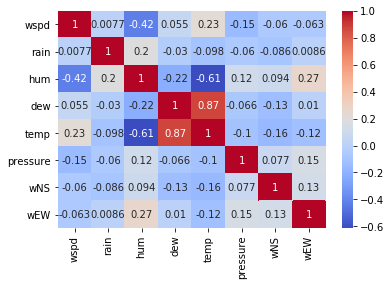

In [35]:
# Get correlation matrix
ts_names = data.columns.drop(["label","ID","lat","long","alt"])
corr_mat = data[ts_names].corr(method="spearman")
import seaborn as sns
sns.heatmap(corr_mat, cmap="coolwarm", annot=True)

In [36]:
import scipy.stats  as stats
print("Rain-Hum correlation:",stats.spearmanr(data[["rain"]],data[["hum"]]))
print("Rain-Temp correlation:",stats.spearmanr(data[["rain"]],data[["temp"]]))
print("Rain-Temp correlation:",stats.spearmanr(data[["rain"]],data[["wNS"]]))

Rain-Hum correlation: SpearmanrResult(correlation=0.19651846382601812, pvalue=0.0)
Rain-Temp correlation: SpearmanrResult(correlation=-0.09841926138331801, pvalue=4.60233325864261e-187)
Rain-Temp correlation: SpearmanrResult(correlation=-0.08591187939240698, pvalue=7.31803710844396e-143)


# Part III - Data Preprocessing

The objective of this section is to:
1. Consolidate the target variable
2. Make sure we have an evenly spaced measurements over time
3. Tackle missing values, NaNs, 99999
7. Create a train set and a test set

**Then we evaluate on a simple decision tree classifier**

Continue with the following:
4. Perform some time series features extraction
5. Additional features Engineering (e.g. add polynomial features)
6. Data normalisation / features scaling

## Target Variable
At that stage, we have a "label" which captures wether or not it was raining in the 6 minutes preceeding each meteorological observation. However, the project is about predicting if there will be rain **in the future**. For that we define an horizon, apply a rolling function, and shift a boolean to capture wether there will be rain in that horizon.

In [37]:
data.head()

,ID,lat,long,alt,wspd,rain,hum,dew,temp,pressure,wNS,wEW,label
date,,,,,,,,,,,,,
2018-01-01 00:00:00,74182001,45.93,6.09,455.0,2.7,0.2,83.0,4.0,6.7,101690.0,-0.766,-0.643,True
2018-01-01 00:06:00,74182001,45.93,6.09,455.0,3.4,0.2,85.0,4.2,6.5,101710.0,-0.940,-0.342,True
2018-01-01 00:12:00,74182001,45.93,6.09,455.0,3.5,0.2,87.0,4.3,6.3,101710.0,-0.985,-0.174,True
2018-01-01 00:18:00,74182001,45.93,6.09,455.0,3.5,0.0,87.0,4.3,6.3,101740.0,-0.985,-0.174,False
2018-01-01 00:24:00,74182001,45.93,6.09,455.0,3.7,0.4,86.0,4.2,6.4,101770.0,-0.866,-0.500,True


In [38]:
# Horizon of 10 covers 6*10 = 60 minutes
horizon = 10 

# We create a new column for the target
data["target"] = data["label"].rolling(horizon).sum().shift(-horizon)>0

In [39]:
data.head()
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 87423 entries, 2018-01-01 00:00:00 to 2018-12-31 23:54:00
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ID        87423 non-null  int64  
 1   lat       87423 non-null  float64
 2   long      87423 non-null  float64
 3   alt       87423 non-null  float64
 4   wspd      87423 non-null  float64
 5   rain      87423 non-null  float64
 6   hum       87423 non-null  float64
 7   dew       87423 non-null  float64
 8   temp      87423 non-null  float64
 9   pressure  87423 non-null  float64
 10  wNS       87423 non-null  float64
 11  wEW       87423 non-null  float64
 12  label     87423 non-null  bool   
 13  target    87423 non-null  bool   
dtypes: bool(2), float64(11), int64(1)
memory usage: 11.3 MB


## Resampling
Below we ensure all observations a spaced by 6min intervals and we convert boolean features into 0-1.

In [40]:
# Resample to get evenly spaced observation and convert booleans to 0-1
data = data.resample("6min").mean()
data.info()
data.head(10)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 87600 entries, 2018-01-01 00:00:00 to 2018-12-31 23:54:00
Freq: 6T
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ID        87423 non-null  float64
 1   lat       87423 non-null  float64
 2   long      87423 non-null  float64
 3   alt       87423 non-null  float64
 4   wspd      87423 non-null  float64
 5   rain      87423 non-null  float64
 6   hum       87423 non-null  float64
 7   dew       87423 non-null  float64
 8   temp      87423 non-null  float64
 9   pressure  87423 non-null  float64
 10  wNS       87423 non-null  float64
 11  wEW       87423 non-null  float64
 12  label     87423 non-null  float64
 13  target    87423 non-null  float64
dtypes: float64(14)
memory usage: 10.0 MB


,ID,lat,long,alt,wspd,rain,hum,dew,temp,pressure,wNS,wEW,label,target
date,,,,,,,,,,,,,,
2018-01-01 00:00:00,74182001.0,45.93,6.09,455.0,2.7,0.2,83.0,4.0,6.7,101690.0,-0.766,-0.643,1.0,1.0
2018-01-01 00:06:00,74182001.0,45.93,6.09,455.0,3.4,0.2,85.0,4.2,6.5,101710.0,-0.940,-0.342,1.0,1.0
2018-01-01 00:12:00,74182001.0,45.93,6.09,455.0,3.5,0.2,87.0,4.3,6.3,101710.0,-0.985,-0.174,1.0,1.0
2018-01-01 00:18:00,74182001.0,45.93,6.09,455.0,3.5,0.0,87.0,4.3,6.3,101740.0,-0.985,-0.174,0.0,1.0
2018-01-01 00:24:00,74182001.0,45.93,6.09,455.0,3.7,0.4,86.0,4.2,6.4,101770.0,-0.866,-0.500,1.0,1.0
2018-01-01 00:30:00,74182001.0,45.93,6.09,455.0,4.5,0.4,81.0,3.3,6.3,101780.0,-0.500,-0.866,1.0,1.0
2018-01-01 00:36:00,74182001.0,45.93,6.09,455.0,3.1,0.4,83.0,3.4,6.1,101780.0,-0.342,-0.940,1.0,1.0
2018-01-01 00:42:00,74182001.0,45.93,6.09,455.0,1.9,0.2,85.0,3.7,6.0,101810.0,-0.766,-0.643,1.0,1.0
2018-01-01 00:48:00,74182001.0,45.93,6.09,455.0,1.5,0.2,88.0,4.1,5.9,101830.0,-0.985,-0.174,1.0,1.0


## Tackle Missing values

In [41]:
print("Missing values:",data.isna().sum())

Missing values: ID          177
lat         177
long        177
alt         177
wspd        177
rain        177
hum         177
dew         177
temp        177
pressure    177
wNS         177
wEW         177
label       177
target      177
dtype: int64


In [42]:
data = data.fillna(method = "ffill")
data.isna().sum()
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 87600 entries, 2018-01-01 00:00:00 to 2018-12-31 23:54:00
Freq: 6T
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ID        87600 non-null  float64
 1   lat       87600 non-null  float64
 2   long      87600 non-null  float64
 3   alt       87600 non-null  float64
 4   wspd      87600 non-null  float64
 5   rain      87600 non-null  float64
 6   hum       87600 non-null  float64
 7   dew       87600 non-null  float64
 8   temp      87600 non-null  float64
 9   pressure  87600 non-null  float64
 10  wNS       87600 non-null  float64
 11  wEW       87600 non-null  float64
 12  label     87600 non-null  float64
 13  target    87600 non-null  float64
dtypes: float64(14)
memory usage: 10.0 MB


## Create Train and Test sets

In [43]:
from sklearn.model_selection import train_test_split

In [44]:
# Extract Model Inputs from data
X = data.drop(["target","ID","lat","long","alt"], axis=1)
X.shape

X.head()

,wspd,rain,hum,dew,temp,pressure,wNS,wEW,label
date,,,,,,,,,
2018-01-01 00:00:00,2.7,0.2,83.0,4.0,6.7,101690.0,-0.766,-0.643,1.0
2018-01-01 00:06:00,3.4,0.2,85.0,4.2,6.5,101710.0,-0.940,-0.342,1.0
2018-01-01 00:12:00,3.5,0.2,87.0,4.3,6.3,101710.0,-0.985,-0.174,1.0
2018-01-01 00:18:00,3.5,0.0,87.0,4.3,6.3,101740.0,-0.985,-0.174,0.0
2018-01-01 00:24:00,3.7,0.4,86.0,4.2,6.4,101770.0,-0.866,-0.500,1.0


In [45]:
# Extract Model Target from data
y = data["target"]
y.head()

date
2018-01-01 00:00:00    1.0
2018-01-01 00:06:00    1.0
2018-01-01 00:12:00    1.0
2018-01-01 00:18:00    1.0
2018-01-01 00:24:00    1.0
Freq: 6T, Name: target, dtype: float64

In [46]:
# Train - Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, \
                                    test_size=0.2, random_state=0)

In [47]:
print("Fraction of positive target in train set",y_train.sum()/len(y_train))
y_train.value_counts()

Fraction of positive target in train set 0.12602739726027398


0.0    61248
1.0     8832
Name: target, dtype: int64

In [48]:
print("Fraction of positive target in test set",y_test.sum()/len(y_test))
y_test.value_counts()

Fraction of positive target in test set 0.1259703196347032


0.0    15313
1.0     2207
Name: target, dtype: int64

## Initial model for pre-processing evaluation
In this section we train and score a simple Decision Tree classifier. This aims at informing wether or not we have to perform features extraction, select features, and generate more features (polynomials), regularize, etc. For this we use the following procedue:
- Build model
- Evaluate model socre (recall and f1-score)
- Diagnostic with model learning curve

In [49]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, recall_score, precision_score,\
confusion_matrix, classification_report
from sklearn.model_selection import learning_curve

In [50]:
# Model
model = DecisionTreeClassifier(random_state = 0)

In [51]:
# Define an evaluation method
def evaluation(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    #print(confusion_matrix(y_test, y_pred))
    #print(classification_report(y_test, y_pred))
    
    print("========================================")
    print("Weather Alert System Performance Report:")
    print("========================================")
    print("Recall :     ",round(recall_score(y_test, y_pred),4))
    print("Precision:   ",round(precision_score(y_test, y_pred),4))
    print("F1 score:    ",round(f1_score(y_test, y_pred),4))
    print("========================================")
    
    N, train_score, val_score = learning_curve(model, X_train, y_train,\
            cv = 4, train_sizes = np.linspace(0.1,1,7), scoring="f1")
    
    plt.figure(figsize=(9,6))
    plt.plot(N, train_score.mean(axis=1), label="train score")
    plt.plot(N, val_score.mean(axis=1), label="validation score")
    plt.title("Learning Curve")
    plt.xlabel("Number of observations")
    plt.ylabel("Score F1")
    plt.ylim([0,1.1])
    
def evaluationSimple(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    #print(confusion_matrix(y_test, y_pred))
    #print(classification_report(y_test, y_pred))
    
    print("========================================")
    print("Weather Alert System Performance Report:")
    print("========================================")
    print("Recall :     ",round(recall_score(y_test, y_pred),4))
    print("Precision:   ",round(precision_score(y_test, y_pred),4))
    print("F1 score:    ",round(f1_score(y_test, y_pred),4))
    print("========================================")

Weather Alert System Performance Report:
Recall :      0.7295
Precision:    0.7389
F1 score:     0.7342


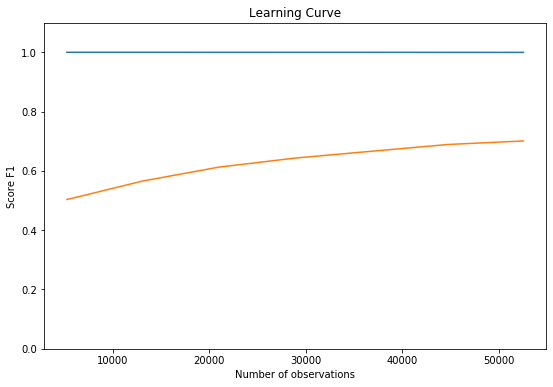

In [52]:
# Implement initial model evaluation
evaluation(model)

## Polynomial Features
Now we will apply a similar procedure but add polynomial features to our model.

**Conclusion:** adding only polynomial features does not seems to help. Indeed, the model seems to overfitt the the train set. 

In [53]:
from sklearn.preprocessing import PolynomialFeatures

from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_classif

In [54]:
X_poly = PolynomialFeatures(degree = 2, include_bias=False).fit_transform(X)

In [55]:
# create train and test set
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, \
                                    test_size=0.2, random_state=0)

In [56]:
# We can see that we increased the number of features (number of columbns)
X_train.shape

(70080, 54)

In [57]:
model = DecisionTreeClassifier(random_state = 0)

#model = make_pipeline(SelectKBest(f_classif, k = 10),
                    #DecisionTreeClassifier(random_state = 0))

Weather Alert System Performance Report:
Recall :      0.6833
Precision:    0.6985
F1 score:     0.6908


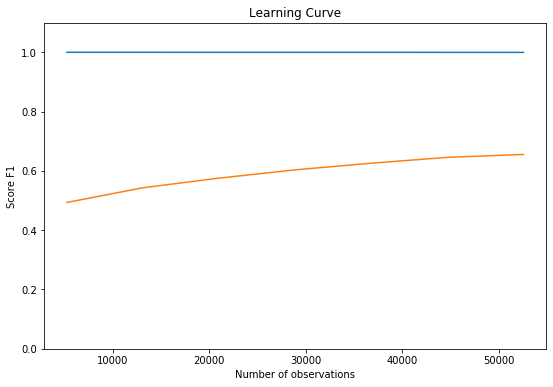

In [58]:
# Evaluation model with polynomial features
evaluation(model)

**Conclusion**

Several configurations were tested and evaluated on the validation set with the f1-score. Here is a summary:

- Without polynomial: f1 = 0.73
- With polynomial ft: f1 = 0.69
- With poly and 50-best: f1 = 0.68
- poly, 40-best: f1 = 0.69
- poly, 30-best: f1 = 0.70
- poly, 20-best: f1 = 0.63
- poly, 10-best: f1 = 0.40

Polynomial features does not seems to help with a simple decision tree classifier. Coupling with a selection of the k-best variable (SelectKBest) was also not helpfull.

## Time series features extraction
A common activity in feature engineering for time series analysis is to extract features given past observations. Indeed, timeseries are often autocorrelated, and past values influences what comes next.

Therefore, in addition to the time point measurement, we will generate the following features over a 4-hour rolling window.
- mean
- min
- max
- std
- delta (final - initial)

Once these new features are created, we evaluate the model performances.

In [59]:
X_past = X[["wspd","rain","hum","dew","temp","pressure"]]
X_past = X_past.rolling(window = 40).aggregate(["mean","std","min","max","sum"])
X_past = X_past.dropna(axis = 0)

In [60]:
print(X_past.shape)
X_past.head()

(87561, 30)


wspd                             rain                 \
                      mean       std  min  max   sum   mean       std  min   
date                                                                         
2018-01-01 03:54:00  2.400  0.882014  0.0  4.5  96.0  0.180  0.168249  0.0   
2018-01-01 04:00:00  2.375  0.887448  0.0  4.5  95.0  0.175  0.170595  0.0   
2018-01-01 04:06:00  2.320  0.890462  0.0  4.5  92.8  0.170  0.172760  0.0   
2018-01-01 04:12:00  2.280  0.871839  0.0  4.5  91.2  0.165  0.174753  0.0   
2018-01-01 04:18:00  2.235  0.853515  0.0  4.5  89.4  0.165  0.174753  0.0   

                               ...    temp                             \
                     max  sum  ...    mean       std  min  max    sum   
date                           ...                                      
2018-01-01 03:54:00  0.6  7.2  ...  5.4100  0.654687  4.5  6.7  216.4   
2018-01-01 04:00:00  0.6  7.0  ...  5.3625  0.627035  4.5  6.5  214.5   
2018-01-01 04:06:00  0.6  6.8  ...  5.3150  0.610401  4.5  6.4  212.6   
2018-01-01 04:12:00  0.6  6.6  ...  5.2675  0.605694  4.4  6.4  210.7   
2018-01-01 04:18:00  0.6  6.6  ...  5.2200  0.597087  4.4  6.4  208.8   

                      pressure                                            
                          mean        std       min       max        sum  
date                                                                      
2018-01-01 03:54:00  101902.75  99.020524  101690.0  102020.0  4076110.0  
2018-01-01 04:00:00  101910.75  94.200754  101710.0  102020.0  4076430.0  
2018-01-01 04:06:00  101918.75  90.218751  101710.0  102030.0  4076750.0  
2018-01-01 04:12:00  101926.75  85.286471  101740.0  102030.0  4077070.0  
2018-01-01 04:18:00  101934.00  81.234071  101770.0  102030.0  4077360.0  

[5 rows x 30 columns]

In [61]:
# We also create features by shifting values from 3, 6, 12, 24 and 48 
# time steps from the past to the current time step. This is to account
# for time lagged correlation.
X_shift3 = X[["wspd","rain","hum","dew","temp","pressure"]].shift(3).add_suffix("_s3")
X_shift6 = X[["wspd","rain","hum","dew","temp","pressure"]].shift(6).add_suffix("_s6")
X_shift12 = X[["wspd","rain","hum","dew","temp","pressure"]].shift(12).add_suffix("_s12")
X_shift24 = X[["wspd","rain","hum","dew","temp","pressure"]].shift(24).add_suffix("_s24")
X_shift48 = X[["wspd","rain","hum","dew","temp","pressure"]].shift(48).add_suffix("_s48")

In [62]:
X_shift3.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 87600 entries, 2018-01-01 00:00:00 to 2018-12-31 23:54:00
Freq: 6T
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   wspd_s3      87597 non-null  float64
 1   rain_s3      87597 non-null  float64
 2   hum_s3       87597 non-null  float64
 3   dew_s3       87597 non-null  float64
 4   temp_s3      87597 non-null  float64
 5   pressure_s3  87597 non-null  float64
dtypes: float64(6)
memory usage: 4.7 MB


In [63]:
# Concatenate all in a final dataFrame
data_lag = pd.concat([data["target"], X, X_past], join = "inner", axis = 1)

#data_lag = pd.concat([data["target"], X, X_past, X_shift3, X_shift6, X_shift12, \
#                      X_shift24, X_shift48], join = "inner", axis = 1)

In [64]:
# Drop missing values:
data_lag = data_lag.dropna(axis = 0)

# Print shape of the dataFrame
data_lag.shape

(87561, 40)

In [65]:
# Extract input features
X_lag = data_lag.drop(["target"], axis = 1)
print(X_lag.shape)
X_lag.head()

(87561, 39)


,wspd,rain,hum,dew,temp,pressure,wNS,wEW,label,"(wspd, mean)",...,"(temp, mean)","(temp, std)","(temp, min)","(temp, max)","(temp, sum)","(pressure, mean)","(pressure, std)","(pressure, min)","(pressure, max)","(pressure, sum)"
date,,,,,,,,,,,,,,,,,,,,,
2018-01-01 03:54:00,2.1,0.0,86.0,2.7,4.8,102000.0,-0.866,0.500,0.0,2.400,...,5.4100,0.654687,4.5,6.7,216.4,101902.75,99.020524,101690.0,102020.0,4076110.0
2018-01-01 04:00:00,1.7,0.0,85.0,2.5,4.8,102010.0,-0.866,0.500,0.0,2.375,...,5.3625,0.627035,4.5,6.5,214.5,101910.75,94.200754,101710.0,102020.0,4076430.0
2018-01-01 04:06:00,1.2,0.0,86.0,2.5,4.6,102030.0,-0.342,-0.940,0.0,2.320,...,5.3150,0.610401,4.5,6.4,212.6,101918.75,90.218751,101710.0,102030.0,4076750.0
2018-01-01 04:12:00,1.9,0.0,89.0,2.7,4.4,102030.0,0.766,-0.643,0.0,2.280,...,5.2675,0.605694,4.4,6.4,210.7,101926.75,85.286471,101740.0,102030.0,4077070.0
2018-01-01 04:18:00,1.7,0.0,89.0,2.7,4.4,102030.0,0.985,-0.174,0.0,2.235,...,5.2200,0.597087,4.4,6.4,208.8,101934.00,81.234071,101770.0,102030.0,4077360.0


In [67]:
# Extract target
y_lag = data_lag["target"]
print(y_lag.shape)
print(y_lag.head())
print(X_lag.head())

(87561,)
date
2018-01-01 03:54:00    0.0
2018-01-01 04:00:00    0.0
2018-01-01 04:06:00    0.0
2018-01-01 04:12:00    0.0
2018-01-01 04:18:00    0.0
Freq: 6T, Name: target, dtype: float64
                     wspd  rain   hum  dew  temp  pressure    wNS    wEW  \
date                                                                       
2018-01-01 03:54:00   2.1   0.0  86.0  2.7   4.8  102000.0 -0.866  0.500   
2018-01-01 04:00:00   1.7   0.0  85.0  2.5   4.8  102010.0 -0.866  0.500   
2018-01-01 04:06:00   1.2   0.0  86.0  2.5   4.6  102030.0 -0.342 -0.940   
2018-01-01 04:12:00   1.9   0.0  89.0  2.7   4.4  102030.0  0.766 -0.643   
2018-01-01 04:18:00   1.7   0.0  89.0  2.7   4.4  102030.0  0.985 -0.174   

                     label  (wspd, mean)  ...  (temp, mean)  (temp, std)  \
date                                      ...                              
2018-01-01 03:54:00    0.0         2.400  ...        5.4100     0.654687   
2018-01-01 04:00:00    0.0         2.375  ...      

In [76]:
y_lag.shape

(87561,)

In [77]:
# create train and test set
X_train, X_test, y_train, y_test = train_test_split(X_lag, y_lag, \
                                    test_size=0.2, random_state=0)

In [78]:
model = DecisionTreeClassifier(random_state=0)

#model = make_pipeline(SelectKBest(f_classif, k = 5),
#                    DecisionTreeClassifier(random_state = 0))

In [79]:
evaluationSimple(model)

Weather Alert System Performance Report:
Recall :      0.8798
Precision:    0.8946
F1 score:     0.8871


**Conclusion**
- X_past values only: f1 = 0.89
- X_past values + shifted values: f1 = 0.86
- X_past + shift + 50-best: f1 = 0.88
- X_past + shift + 40-best: f1 = 0.86
- X_past + shift + 30-best: f1 = 0.86
- X_past + shift + 20-best: f1 = 0.81
- X_past + shift + 10-best: f1 = 0.64
- X_past + shift + 5-best: f1 = 0.63

**Features extracted from past values and shifted values seems to have a positive effect on the predictive capabilities of the model.**

## Analysis of Feature Importance
Below we plot the feature importance. We can clearly see that the most influencial feature is the sum of precipiation over last 4 hours. This makes sense. Other factors are way less influencial, but appears to still contribute to the classification performance since SelectKbest was not helpful.

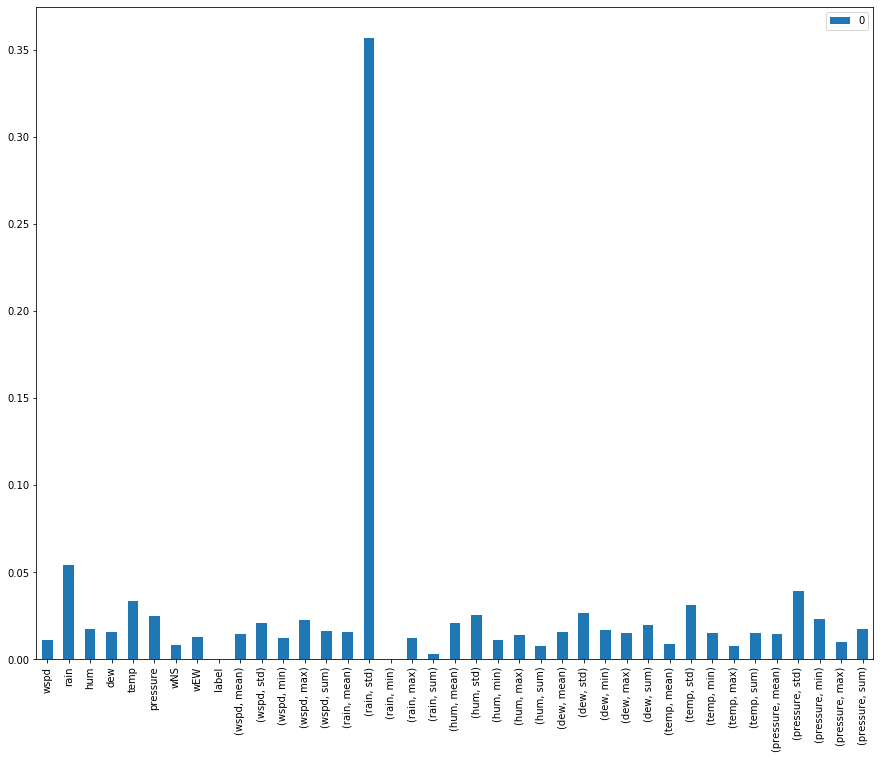

In [80]:
pd.DataFrame(model.feature_importances_, index=data_lag.drop(["target"],axis=1).columns).plot.bar(figsize=(15,12))

# Part IV - Modelling and Optimisation
In this section, we evaluate various classification algorithms:

- Decision Tree
- Random Forest
- AdaBoostClassifier
- Support Vector Classifier
- K-neighbors classifier

Then, we select the best classifier and proceed by tuning its hyper-parameters.

In [81]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Part I
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# To test
#from sklearn.naive_bayes import ComplementNB
#from sklearn.neural_network import MLPClassifier
#from sklearn.linear_model import SGDClassifier
#from sklearn.gaussian_process import GaussianProcessClassifier
#from sklearn.gaussian_process.kernels import RBF

#clf = ComplementNB()
#clf.fit(X, y)

#clf = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1)

#clf = SGDClassifier(loss="hinge", penalty="l2", max_iter=5)

#kernel = 1.0 * RBF(1.0)
#gpc = GaussianProcessClassifier(kernel=kernel,random_state=0).fit(X, y)

In [82]:
# We define several models with make_pipeline. This allows to 
# used standard scaler for SVM and KNN algo.
DecisionTree = make_pipeline(DecisionTreeClassifier(random_state=0))

RandomForest = make_pipeline(RandomForestClassifier(random_state = 0)) # based on decision tree
# so no need to normalise data

AdaBoost = make_pipeline(AdaBoostClassifier(random_state = 0)) # based on decision tree,
# no need to normalise data

SVM = make_pipeline(StandardScaler(), SVC(random_state=0))

KNN = make_pipeline(StandardScaler(), KNeighborsClassifier())

In [83]:
# We gather models in a dictionnary
dict_of_models = {"DecisionTree" : DecisionTree, 
                  "RandomForest": RandomForest,
                  "AdaBoost" : AdaBoost,
                  "SVM":SVM,
                  "KNN":KNN}

**Finally we evaluate each model:**

DecisionTree
Recall :      0.8523
Precision:    0.8722
F1 score:     0.8621

RandomForest
Recall :      0.9234
Precision:    0.9401
F1 score:     0.9317

AdaBoost
Recall :      0.5324
Precision:    0.73
F1 score:     0.6157

SVM:
Recall :      0.5392
Precision:    0.8414
F1 score:     0.6572

KNN
Recall :      0.8696
Precision:    0.8817
F1 score:     0.8756

**We notice that the best performing algorithm is RANDOM FOREST**

In [84]:
# After evaluation of all models, it seems that RandomForest gives the best performances
evaluationSimple(RandomForest)

Weather Alert System Performance Report:
Recall :      0.9413
Precision:    0.9474
F1 score:     0.9443


In [85]:
# Displays the RandomFor
RandomForest

Pipeline(memory=None,
         steps=[('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=100, n_jobs=None,
                                        oob_score=False, random_state=0,
                                        verbose=0, warm_start=False))],
         verbose=False)

## Hyper-parameters tuning
In the following we define the hyper-parameters tuned. Due to the great variety of combination, we use a RandomizedSearchCV instead of a tyipical GridSearchCV. The aim of this section is to figure out what hyperparameters allows to obtain the highest f1-score on the validation set.

In [98]:
hyper_params = {'randomforestclassifier__max_depth': [75, 150, None],
 'randomforestclassifier__n_estimators': [50,100,150,200]}

In [99]:
randomGrid = RandomizedSearchCV( RandomForest, hyper_params, n_iter=10, scoring = "f1", \
                          cv = 4, random_state = 0, verbose=2)

randomGrid.fit(X_train, y_train)
print(randomGrid.best_params_)

Fitting 4 folds for each of 10 candidates, totalling 40 fits
[CV] randomforestclassifier__n_estimators=150, randomforestclassifier__max_depth=150 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  randomforestclassifier__n_estimators=150, randomforestclassifier__max_depth=150, total=  35.6s
[CV] randomforestclassifier__n_estimators=150, randomforestclassifier__max_depth=150 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   35.6s remaining:    0.0s


[CV]  randomforestclassifier__n_estimators=150, randomforestclassifier__max_depth=150, total=  34.8s
[CV] randomforestclassifier__n_estimators=150, randomforestclassifier__max_depth=150 
[CV]  randomforestclassifier__n_estimators=150, randomforestclassifier__max_depth=150, total=  36.2s
[CV] randomforestclassifier__n_estimators=150, randomforestclassifier__max_depth=150 
[CV]  randomforestclassifier__n_estimators=150, randomforestclassifier__max_depth=150, total=  34.7s
[CV] randomforestclassifier__n_estimators=200, randomforestclassifier__max_depth=None 
[CV]  randomforestclassifier__n_estimators=200, randomforestclassifier__max_depth=None, total=  46.4s
[CV] randomforestclassifier__n_estimators=200, randomforestclassifier__max_depth=None 
[CV]  randomforestclassifier__n_estimators=200, randomforestclassifier__max_depth=None, total=  46.4s
[CV] randomforestclassifier__n_estimators=200, randomforestclassifier__max_depth=None 
[CV]  randomforestclassifier__n_estimators=200, randomforest

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed: 63.1min finished


{'randomforestclassifier__n_estimators': 150, 'randomforestclassifier__max_depth': 150}


To do:
- Hyperparameter Tuning
- Ensemble Method
- Precision-Recall trade-off

In [101]:
print(randomGrid.best_score_)
print(randomGrid.best_params_)

0.9308991469781138
{'randomforestclassifier__n_estimators': 150, 'randomforestclassifier__max_depth': 150}


In [113]:
# Use the test set to make predictions
y_pred = model.predict(X_test)

# Compute f1-score on the test set
test_score = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print("Test set Precision-Score :",round(recall,4))
print("Test set Recall-Score :",round(precision,4))
print("Test set F1-Score :",round(test_score,4))

Test set Precision-Score : 0.8798
Test set Recall-Score : 0.8946
Test set F1-Score : 0.8871


The f1-score on the validation set was 0.94 while evaluation on the test set gives 0.88. This suggests that overall the model has slightly overfitted the training/validation set.

Nevertheless, a score of 0.887 is entirely satisfactory for this feasibility study.

## Conclusion & Futur Work

This project has demonstrated that, given the weather records for the past 4 hours, a RandomForest algorithm can predict wether there will be precipiation or not within the next 4 hours, with f1-score of 88.7%.

As futur work, it is recommended to investigate by how much the performance drops with an increase of the prediction window.